# **IBL - Raw Mesoscope Imaging Data**

This tutorial shows how to access data from <[DANDI:00XXXX](https://dandiarchive.org/dandiset/00XXXX/draft)> for the IBL mesoscope dataset

## Study Overview

[TODO add description]

## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [Raw Imaging Data and Metadata](#raw)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [4]:
# Core data manipulation and analysis
from pathlib import Path

import h5py

# Visualization
import matplotlib.pyplot as plt
import remfile
from dandi.dandiapi import DandiAPIClient

# NWB and DANDI access
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Access Functions

In [5]:
def load_nwb_from_dandi(dandiset_id, subject_id, session_id):
    """
    Load NWB file from DANDI Archive via streaming.
    """
    pattern = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}*.nwb"
    
    with DandiAPIClient() as client:
        client.dandi_authenticate()
        assets = client.get_dandiset(dandiset_id, "draft").get_assets_by_glob(
            pattern=pattern, order="path"
        )
        
        s3_urls = []
        for asset in assets:
            s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
            s3_urls.append(s3_url)
        
        if len(s3_urls) != 1:
            raise ValueError(f"Expected 1 file, found {len(s3_urls)} for pattern {pattern}")
        
        s3_url = s3_urls[0]
    
    file = remfile.File(s3_url)
    h5_file = h5py.File(file, "r")
    io = NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io


def load_nwb_local(directory_path, subject_id, session_id):
    """
    Load NWB file from local directory.
    """
    directory_path = Path(directory_path)
    nwbfile_path = directory_path / f"sub-{subject_id}_ses-{session_id}_desc-raw_behavior+ophys.nwb"
    if not nwbfile_path.exists():
        raise FileNotFoundError(f"NWB file not found: {nwbfile_path}")

    io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
    nwbfile = io.read()

    return nwbfile, io

---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [6]:
# Load session data
dandiset_id = "00XXXX" #TODO Replace with actual DANDI dandiset ID
subject_id = "SP061"  # Example subject
session_id = "5ce2e17e-8471-42d4-8a16-21949710b328"  # EID for the session
# session_id = "42d7e11e-3185-4a79-a6ad-bbaf47366db2"  # EID for the session

# Choose data source (DANDI streaming or local)
USE_DANDI = False  # Set to False to use local files

if USE_DANDI:
    nwbfile, io = load_nwb_from_dandi(dandiset_id, subject_id, session_id)
else:
    # Specify your local directory path
    local_directory = f"E:/IBL-data-share/nwbfiles/stub/sub-{subject_id}"
    nwbfile, io = load_nwb_local(local_directory, subject_id, session_id)

print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

=== SESSION INFORMATION ===
Experiment description:
 None
Session description:
 A rich text description of the experiment. Can also just be the abstract of the publication.
Session start time:
 2025-01-28 10:49:59+00:00


In [7]:
print("=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Strain: {nwbfile.subject.species}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SUBJECT INFORMATION ===
ID: SP061
Age: None
Strain: Mus musculus
Genotype: None
Sex: F


---

# 3. Raw Imaging Data and Metadata <a id="raw"></a>

## Imaging Metadata

In [8]:
print("=== IMAGING METADATA ===")
print("All imaging metadata are stored in the imaging module in imaging_planes:")
print("-" * 100)
for plane_name in nwbfile.imaging_planes:
    plane = nwbfile.imaging_planes[plane_name]
    print(f"Imaging Plane: {plane_name}")
    print("-" * 100)
    print(f"  Description: {plane.description}")
    print(f"  Imaging Rate: {plane.imaging_rate} Hz")
    print(f"  Optical Channel: {plane.optical_channel[0].name}, {plane.optical_channel[0].description}")
    print(f"  Indicator: {plane.indicator}")
    print(f"  Excitation Wavelength: {plane.excitation_lambda} nm")
    print(f"  Emission Wavelength: {plane.optical_channel[0].emission_lambda} nm")
    print(f"  Location: {plane.location}")
    # print(
    #     f"  Origin Coordinates (top left of the FOV):\n\tX \t{plane.origin_coords[0]*1e6} um\n\tY \t{plane.origin_coords[1]*1e6} um\n\tZ \t{plane.origin_coords[2]*1e6} um"
    # )
    # print(f"  Grid Spacing:\n\tX \t{plane.grid_spacing[0]*1e6} um\n\tY \t{plane.grid_spacing[1]*1e6} um")
    print("-"*100)

=== IMAGING METADATA ===
All imaging metadata are stored in the imaging module in imaging_planes:
----------------------------------------------------------------------------------------------------
Imaging Plane: ImagingPlaneFOV00
----------------------------------------------------------------------------------------------------
  Description: Field of view 0 (UUID: CCE276EFA6244E74). Image dimensions: 512x512 pixels.
  Imaging Rate: 5.07538 Hz
  Optical Channel: OpticalChannel, GCaMP6s emission.
  Indicator: GCaMP6s
  Excitation Wavelength: 920.0 nm
  Emission Wavelength: 510.0 nm
  Location: Brain region ID 450 (Allen CCF 2017)
----------------------------------------------------------------------------------------------------
Imaging Plane: ImagingPlaneFOV01
----------------------------------------------------------------------------------------------------
  Description: Field of view 1 (UUID: FBEB99A903F6F6DB). Image dimensions: 512x512 pixels.
  Imaging Rate: 5.07538 Hz
  Optic

In [9]:
print("=== MESOSCOPE SETUP INFORMATION ===")
nwbfile.devices["TwoPhotonMesoscope"]

=== MESOSCOPE SETUP INFORMATION ===


TwoPhotonMesoscope pynwb.device.Device at 0x2398618510608
Fields:
  description: The two photon mesoscope used to acquire green fluorescence on several FOVs.

## Two Photon Series - Raw Imaging Data

In [10]:
print("=== OPHYS ACQUISITION MODULE ===\n")
two_photon_series_names = []
for name, proc in nwbfile.acquisition.items():
    if "TwoPhoton" not in name:
        continue
    print(f"{name} - {proc.description}")
    two_photon_series_names.append(name)

=== OPHYS ACQUISITION MODULE ===

TwoPhotonSeriesFOV00Task00 - The raw two-photon imaging data acquired using the mesoscope on FOV_00 (UUID: CCE276EFA6244E74) .
TwoPhotonSeriesFOV00Task01 - The raw two-photon imaging data acquired using the mesoscope on FOV_00 (UUID: CCE276EFA6244E74) .
TwoPhotonSeriesFOV01Task00 - The raw two-photon imaging data acquired using the mesoscope on FOV_01 (UUID: FBEB99A903F6F6DB) .
TwoPhotonSeriesFOV01Task01 - The raw two-photon imaging data acquired using the mesoscope on FOV_01 (UUID: FBEB99A903F6F6DB) .


In [ ]:
# Access data of one example FOV
two_photon_series = nwbfile.acquisition[two_photon_series_names[0]]

print("=== RAW TWO-PHOTON SERIES ===")
print(f"Name: {two_photon_series.name}")
print(f"Description: {two_photon_series.description}")
print(f"Data shape: {two_photon_series.data.shape}")
print(f"Duration: {two_photon_series.timestamps[-1] - two_photon_series.timestamps[0]:.2f} seconds")
print(f"Start: {two_photon_series.timestamps[0]}, End: {two_photon_series.timestamps[-1]}")

=== RAW TWO-PHOTON SERIES ===
Name: TwoPhotonSeriesFOV01Task01
Description: The raw two-photon imaging data acquired using the mesoscope on FOV_01 (UUID: FBEB99A903F6F6DB) .
Data shape: (100, 512, 512)
Duration: 19.52 seconds
Start: 0.0, End: 19.52051453


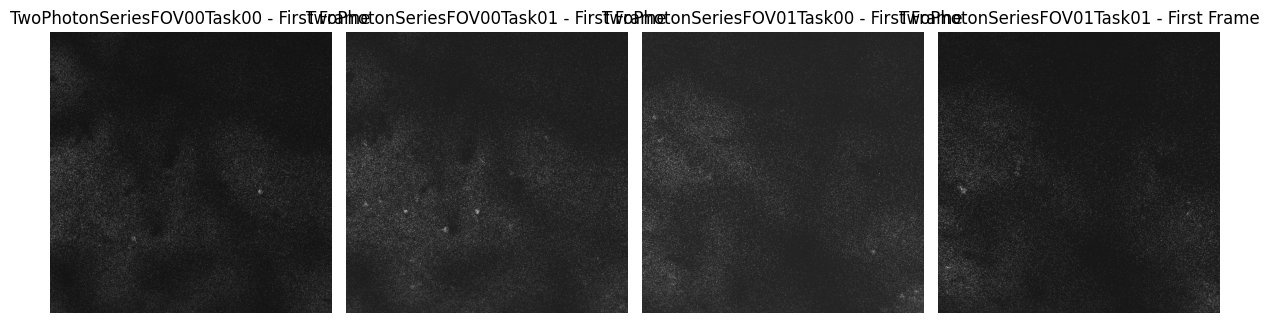

In [12]:
fig, axes = plt.subplots(1, len(two_photon_series_names), sharex=True, sharey=True, dpi=100)
for i, name in enumerate(two_photon_series_names):
    two_photon_series = nwbfile.acquisition[name]
    axes[i].imshow(two_photon_series.data[0, ...], cmap="gray")
    axes[i].set_title(f"{name} - First Frame")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

TODO:
1. PLAY SHORT VIDEO TO DEMO ONE 2P SERIES
2. ADD SCHEMA OF DATA-METADATA RELATION